In [1]:
!sudo apt update

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [76.4 kB]
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [995 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/r

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [5]:
!pip install -q findspark

In [6]:
import findspark
findspark.init()

In [7]:
from pyspark.context import SparkContext
#create SparkContext
sc = SparkContext("local", "My First Spark Application")
print("SparkContext :",sc)

SparkContext : <SparkContext master=local appName=My First Spark Application>


In [8]:
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [9]:
df = spark.read.csv('/content/Churn_Modelling.csv', header=True, inferSchema=True)

In [ ]:
df.printSchema()

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [ ]:
df.count()

10000

In [ ]:
df.distinct().count()

10000

In [ ]:
lst = ['CreditScore','Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df.select(lst).describe().show()

+-------+-----------------+------------------+------------------+-----------------+------------------+-----------------+
|summary|      CreditScore|               Age|            Tenure|          Balance|     NumOfProducts|  EstimatedSalary|
+-------+-----------------+------------------+------------------+-----------------+------------------+-----------------+
|  count|            10000|             10000|             10000|            10000|             10000|            10000|
|   mean|         650.5288|           38.9218|            5.0128|76485.88928799961|            1.5302|100090.2398809998|
| stddev|96.65329873613035|10.487806451704587|2.8921743770496837|62397.40520238599|0.5816543579989917|57510.49281769821|
|    min|              350|                18|                 0|              0.0|                 1|            11.58|
|    max|              850|                92|                10|        250898.09|                 4|        199992.48|
+-------+-----------------+-----

In [ ]:
df.agg({'Balance':'skewness'}).show()
df.agg({'CreditScore':'skewness'}).show()
df.agg({'EstimatedSalary':'skewness'}).show()

+-------------------+
|  skewness(Balance)|
+-------------------+
|-0.1410875437529113|
+-------------------+

+---------------------+
|skewness(CreditScore)|
+---------------------+
| -0.07159586676212142|
+---------------------+

+-------------------------+
|skewness(EstimatedSalary)|
+-------------------------+
|     0.002085044844874...|
+-------------------------+



In [ ]:
df.agg({'Balance':'kurtosis'}).show()
df.agg({'CreditScore':'kurtosis'}).show()
df.agg({'EstimatedSalary':'kurtosis'}).show()

+-------------------+
|  kurtosis(Balance)|
+-------------------+
|-1.4892671063153264|
+-------------------+

+---------------------+
|kurtosis(CreditScore)|
+---------------------+
|   -0.426112791765187|
+---------------------+

+-------------------------+
|kurtosis(EstimatedSalary)|
+-------------------------+
|       -1.181527710874244|
+-------------------------+



In [ ]:
lst1 = ['CreditScore', 'Balance', 'EstimatedSalary']
dicts = {}
for col in lst1:
  quantitles = df.approxQuantile(col, [0.25, 0.75], 0.05)
  iqr = quantitles[1] - quantitles[0]
  dicts[col] = [quantitles[0] - 1.5*iqr , quantitles[1] + 1.5*iqr]

In [ ]:
dicts

{'CreditScore': [408.0, 888.0],
 'Balance': [-185753.28, 309588.8],
 'EstimatedSalary': [-78892.52000000002, 275789.88]}

In [ ]:
df.groupby('Geography').agg(count('Geography'), avg('Age') , avg('Tenure') ,avg('CreditScore'),avg('Balance'), avg('EstimatedSalary')).show()

+---------+----------------+------------------+-----------------+-----------------+------------------+--------------------+
|Geography|count(Geography)|          avg(Age)|      avg(Tenure)| avg(CreditScore)|      avg(Balance)|avg(EstimatedSalary)|
+---------+----------------+------------------+-----------------+-----------------+------------------+--------------------+
|  Germany|            2509|39.771622160223195|5.009964129135113|651.4535671582304|119730.11613391782|   101113.4351016342|
|   France|            5014| 38.51176705225369|5.004587155963303|649.6683286796969|  62092.6365157559|   99899.18081372172|
|    Spain|            2477| 38.89099717400081| 5.03229713362939|651.3338716188938| 61818.14776342349|   99440.57228098497|
+---------+----------------+------------------+-----------------+-----------------+------------------+--------------------+



In [ ]:
df.groupby('Gender').agg( count('Gender'),avg('Age') , avg('Tenure') ,avg('CreditScore'),avg('Balance'), avg('EstimatedSalary')).show()

+------+-------------+------------------+-----------------+-----------------+-----------------+--------------------+
|Gender|count(Gender)|          avg(Age)|      avg(Tenure)| avg(CreditScore)|     avg(Balance)|avg(EstimatedSalary)|
+------+-------------+------------------+-----------------+-----------------+-----------------+--------------------+
|Female|         4543|39.238388729914156|4.966101694915254| 650.831388950033|75659.36913933513|  100601.54138234648|
|  Male|         5457|38.658237126626354|5.051676745464541|650.2768920652373|77173.97450613906|   99664.57693054806|
+------+-------------+------------------+-----------------+-----------------+-----------------+--------------------+



In [ ]:
df.groupby('Surname').agg(avg('Balance'), count('Surname').alias('count')).orderBy('avg(Balance)', ascending = False).show(10)

+-----------+------------+-----+
|    Surname|avg(Balance)|count|
+-----------+------------+-----+
|     To Rot|   238387.56|    1|
|     Haddon|   222267.63|    1|
| Despeissis|   203715.15|    1|
|     Stokes|   202904.64|    1|
|     Bancks|   201009.64|    1|
|Christopher|   195238.29|    1|
|    Hopwood|   191523.09|    1|
|       Slye|   191402.82|    1|
|   Belousov|   189443.72|    1|
|      Foran|   188455.19|    1|
+-----------+------------+-----+
only showing top 10 rows



In [86]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
df.show(5)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|

In [95]:
cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
dicts_c = {}
for col in cols:
  dicts_c[col] = df.select(col).filter(df[col].isNotNull()).rdd.flatMap(lambda row: row).collect()

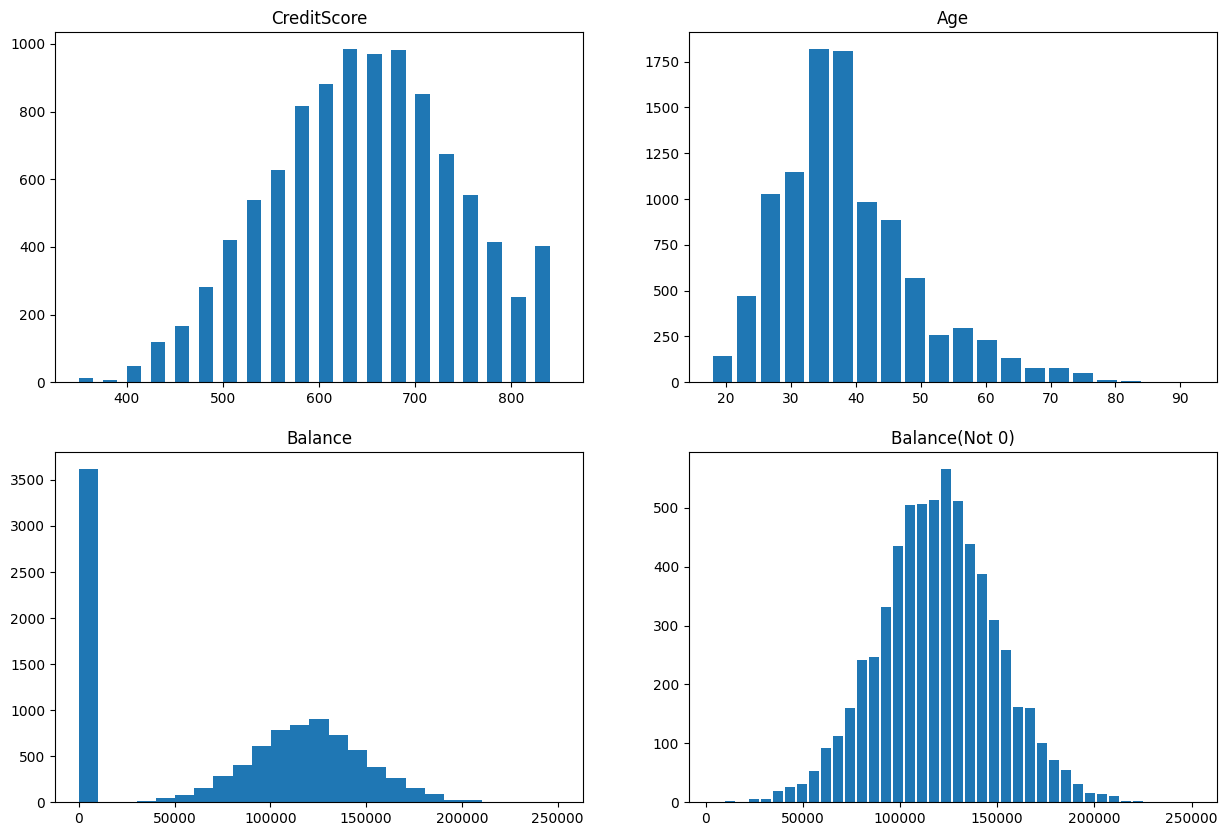

In [96]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
ax1.hist(dicts_c['CreditScore'], bins = 20, width = 15)
ax1.set(title = 'CreditScore')

ax2.hist(dicts_c['Age'], bins = 20 , width = 3)
ax2.set(title = 'Age')

ax3.hist(dicts_c['Balance'], bins = 25)
ax3.set(title = 'Balance')

dicts_c['Balance'] = [value for value in dicts_c['Balance'] if value]
ax4.hist(dicts_c['Balance'], bins = 40, width = 5000)
ax4.set(title = 'Balance(Not 0)')

plt.show()

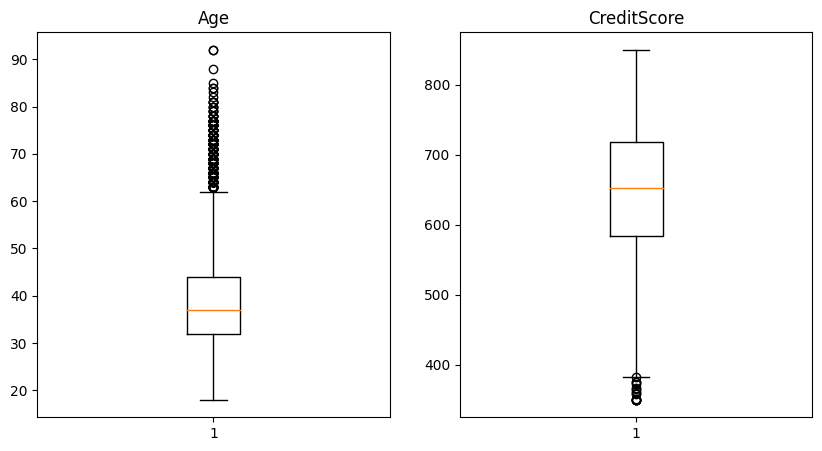

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
ax1.boxplot(dicts_c['Age'])
ax1.set(title = 'Age')
ax2.boxplot(dicts_c['CreditScore'])
ax2.set(title = 'CreditScore')
plt.show()

In [10]:
df1 = df.select([col for col in df.columns[2:]])
df0 = df1

In [ ]:
df1.show(5)

+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|    Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|
|Mitchell|        850|    Spain|Female| 43|     2|125510.82|            1|        1|             1|        79084.1|     0|
+--------+------

In [11]:
from pyspark.ml.feature import StringIndexer

In [12]:
indexer = StringIndexer(inputCols=["Surname","Geography", "Gender"], outputCols=["Surname_index", "Geography_index", "Gender_index"])
data = indexer.fit(df1).transform(df1)

In [13]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                                 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Surname_index', 
                                 'Geography_index', 'Gender_index'],outputCol='features')
data = assembler.transform(data)

In [14]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Exited')

In [15]:
df_train, df_test = data.randomSplit([0.7, 0.3] , seed = 123)

In [16]:
model = lr.fit(df_train)

In [17]:
test_model = model.transform(df_test)

In [18]:
test_model.take(1)

[Row(Surname='Abbie', CreditScore=818, Geography='France', Gender='Female', Age=31, Tenure=1, Balance=186796.37, NumOfProducts=1, HasCrCard=0, IsActiveMember=0, EstimatedSalary=178252.63, Exited=0, Surname_index=1374.0, Geography_index=0.0, Gender_index=1.0, features=DenseVector([818.0, 31.0, 1.0, 186796.37, 1.0, 0.0, 0.0, 178252.63, 1374.0, 0.0, 1.0]), rawPrediction=DenseVector([0.8178, -0.8178]), probability=DenseVector([0.6938, 0.3062]), prediction=0.0)]

In [19]:
test_model.show(5)

+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-------------+---------------+------------+--------------------+--------------------+--------------------+----------+
|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Surname_index|Geography_index|Gender_index|            features|       rawPrediction|         probability|prediction|
+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-------------+---------------+------------+--------------------+--------------------+--------------------+----------+
|    Abbie|        818|   France|Female| 31|     1|186796.37|            1|        0|             0|      178252.63|     0|       1374.0|            0.0|         1.0|[818.0,31.0,1.0,1...|[0.81781058640990...|[0.69377139083150...|       0.0|
|   Abbott|        850|   France|  M

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [21]:
evaluator =BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Exited", metricName="areaUnderROC")

In [22]:
print('Area Under ROC = %g'%evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderROC'}))
print('Area Under PR = %g'%evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderPR'}))

Area Under ROC = 0.752328
Area Under PR = 0.446535


In [23]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="Exited")
print("Accuracy = %g" %evaluator.evaluate(test_model, {evaluator.metricName: "accuracy"}))
print("F1-score = %g" %evaluator.evaluate(test_model, {evaluator.metricName: "f1"}))
print('Recall = %g'%evaluator.evaluate(test_model, {evaluator.metricName: 'weightedRecall'}))
print('Balance accurary = %g'%evaluator.evaluate(test_model, {evaluator.metricName: 'weightedPrecision'}))

Accuracy = 0.813438
F1-score = 0.766852
Recall = 0.813438
Balance accurary = 0.786514


In [24]:
from pyspark.ml import Pipeline

In [25]:
pipeline = Pipeline(stages = [assembler, lr])

In [26]:
df0 =indexer.fit(df0).transform(df0)

In [27]:
df_train2, df_test2 = df0.randomSplit([0.7, 0.3] ,seed = 123)

In [28]:
model2 = pipeline.fit(df_train2)

In [29]:
test_model2 = model2.transform(df_test2)

In [30]:
test_model2.show(5)

+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-------------+---------------+------------+--------------------+--------------------+--------------------+----------+
|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Surname_index|Geography_index|Gender_index|            features|       rawPrediction|         probability|prediction|
+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-------------+---------------+------------+--------------------+--------------------+--------------------+----------+
|    Abbie|        818|   France|Female| 31|     1|186796.37|            1|        0|             0|      178252.63|     0|       1374.0|            0.0|         1.0|[818.0,31.0,1.0,1...|[0.81781058640990...|[0.69377139083150...|       0.0|
|   Abbott|        850|   France|  M

In [31]:
path = '...'
pipeline.write().overwrite().save(path)

In [32]:
loadedpipeline = Pipeline.load(path)

In [33]:
model_load = loadedpipeline.fit(df_train2).transform(df_test2)

In [34]:
model_load.show(5)

+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-------------+---------------+------------+--------------------+--------------------+--------------------+----------+
|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Surname_index|Geography_index|Gender_index|            features|       rawPrediction|         probability|prediction|
+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-------------+---------------+------------+--------------------+--------------------+--------------------+----------+
|    Abbie|        818|   France|Female| 31|     1|186796.37|            1|        0|             0|      178252.63|     0|       1374.0|            0.0|         1.0|[818.0,31.0,1.0,1...|[0.81781058640990...|[0.69377139083150...|       0.0|
|   Abbott|        850|   France|  M

In [35]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="Exited")
print("Accuracy = %g" %evaluator.evaluate(model_load, {evaluator.metricName: "accuracy"}))
print("F1-score = %g" %evaluator.evaluate(model_load, {evaluator.metricName: "f1"}))
print('Recall = %g'%evaluator.evaluate(model_load, {evaluator.metricName: 'weightedRecall'}))
print('Balance accurary = %g'%evaluator.evaluate(model_load, {evaluator.metricName: 'weightedPrecision'}))

Accuracy = 0.813438
F1-score = 0.766852
Recall = 0.813438
Balance accurary = 0.786514


In [76]:
dfn = df0.select('CreditScore' , *[col for col in df0.columns[4:]])

In [49]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
vector_col = 'corr_features'
input_col = ['CreditScore','Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Surname_index', 'Geography_index', 'Gender_index']
assembler = VectorAssembler(inputCols=dfn.columns, outputCol=vector_col)
df_vector = assembler.transform(dfn).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col)

In [54]:
matrix = Correlation.corr(df_vector, 'corr_features').collect()[0][0] 

In [57]:
import pandas as pd
corr_matrix = matrix.toArray().tolist() 

In [60]:
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = input_col, index=input_col) 
corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-60-5b7ed136bd29>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Surname_index,Geography_index,Gender_index
CreditScore,1.00,-0.00,0.00,0.01,0.01,-0.01,0.03,-0.00,-0.03,0.02,0.01,0.00
Age,-0.00,1.00,-0.01,0.03,-0.03,-0.01,0.09,-0.01,0.29,0.01,0.02,0.03
Tenure,0.00,-0.01,1.00,-0.01,0.01,0.02,-0.03,0.01,-0.01,-0.02,0.00,-0.01
Balance,0.01,0.03,-0.01,1.00,-0.30,-0.01,-0.01,0.01,0.12,-0.01,0.07,-0.01
NumOfProducts,0.01,-0.03,0.01,-0.30,1.00,0.00,0.01,0.01,-0.05,-0.01,0.00,0.02
HasCrCard,-0.01,-0.01,0.02,-0.01,0.00,1.00,-0.01,-0.01,-0.01,0.00,-0.01,-0.01
IsActiveMember,0.03,0.09,-0.03,-0.01,0.01,-0.01,1.00,-0.01,-0.16,0.01,0.01,-0.02
EstimatedSalary,-0.00,-0.01,0.01,0.01,0.01,-0.01,-0.01,1.00,0.01,0.00,-0.00,0.01
Exited,-0.03,0.29,-0.01,0.12,-0.05,-0.01,-0.16,0.01,1.00,-0.01,0.04,0.11
Surname_index,0.02,0.01,-0.02,-0.01,-0.01,0.00,0.01,0.00,-0.01,1.00,-0.00,0.00


In [74]:
variable_pre = ['Age','Balance','EstimatedSalary', 'Geography_index', 'Gender_index']

In [65]:
dfn.show(5)

+-----------+---+------+---------+-------------+---------+--------------+---------------+------+-------------+---------------+------------+
|CreditScore|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Surname_index|Geography_index|Gender_index|
+-----------+---+------+---------+-------------+---------+--------------+---------------+------+-------------+---------------+------------+
|        619| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|       1958.0|            0.0|         1.0|
|        608| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|         79.0|            2.0|         1.0|
|        502| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|        336.0|            0.0|         1.0|
|        699| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|        128.0|            0.0|         1.0|
|        850| 43|   

In [77]:
assembler = VectorAssembler(inputCols=variable_pre ,outputCol='features')
dfn = assembler.transform(dfn)

In [78]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Exited')

In [79]:
df_train, df_test = dfn.randomSplit([0.7, 0.3] , seed = 645)
model_new = lr.fit(df_train)
test_model_new = model_new.transform(df_test)
test_model_new.show(5)

+-----------+---+------+---------+-------------+---------+--------------+---------------+------+-------------+---------------+------------+--------------------+--------------------+--------------------+----------+
|CreditScore|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Surname_index|Geography_index|Gender_index|            features|       rawPrediction|         probability|prediction|
+-----------+---+------+---------+-------------+---------+--------------+---------------+------+-------------+---------------+------------+--------------------+--------------------+--------------------+----------+
|        358| 52|     8|143542.36|            3|        1|             0|      141959.11|     1|       1385.0|            2.0|         1.0|[52.0,143542.36,1...|[-0.0663399484096...|[0.48342109275034...|       1.0|
|        365| 30|     0|127760.07|            1|        1|             0|       81537.85|     1|       1278.0|            1.0|         0.0|[30.0

In [80]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="Exited")
print("Accuracy = %g" %evaluator.evaluate(test_model_new, {evaluator.metricName: "accuracy"}))
print("F1-score = %g" %evaluator.evaluate(test_model_new, {evaluator.metricName: "f1"}))
print('Recall = %g'%evaluator.evaluate(test_model_new, {evaluator.metricName: 'weightedRecall'}))
print('Balance accurary = %g'%evaluator.evaluate(test_model_new, {evaluator.metricName: 'weightedPrecision'}))

Accuracy = 0.780268
F1-score = 0.722842
Recall = 0.780268
Balance accurary = 0.714051


In [81]:
evaluator =BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Exited", metricName="areaUnderROC")
print('Area Under ROC = %g'%evaluator.evaluate(test_model_new, {evaluator.metricName: 'areaUnderROC'}))
print('Area Under PR = %g'%evaluator.evaluate(test_model_new, {evaluator.metricName: 'areaUnderPR'}))

Area Under ROC = 0.730652
Area Under PR = 0.37242
